In [5]:
# Loading the packages
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, KFold, StratifiedKFold
from sklearn.linear_model import  LogisticRegression
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import VotingClassifier

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras.metrics import accuracy
import warnings
import seaborn as sns
from sklearn.pipeline import make_pipeline
from scipy.stats import spearmanr
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import roc_auc_score
from scipy.stats import uniform, randint
from sklearn.datasets import make_classification
from sklearn.calibration import calibration_curve
from sklearn.calibration import CalibratedClassifierCV
from matplotlib import pyplot
from sklearn.metrics import plot_roc_curve, roc_curve
import random
from scipy import stats

In [6]:
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

# Customized Standardization
def cust_standardize(dataset):
    dataset_returned = pd.DataFrame()
    for element in dataset.columns:
        if (dataset[element] == dataset[element].iloc[0]).all():
            dataset_returned[element] = dataset[element]
        else:
            dataset_returned[element] = (dataset[element] - np.mean(dataset[element]))/np.std(dataset[element])
    return dataset_returned

# No preprocess on features needed here
def bootstrap_feature_selection(feature_dataset, target_dataset, test_size, num_select, num_iter = 5):
    selected_list = []
    event_dict = {}
    param_grid = {
        'logisticregression__C': 10.0**np.arange(-5, 5, step = 0.1)
    }
    for i in np.arange(num_iter):
        skf = StratifiedKFold(n_splits=5, shuffle = True)
        for train_index, test_index in skf.split(feature_dataset, target_dataset):
            X_train, X_test = X_over.iloc[train_index], X_over.iloc[test_index]
            y_train, y_test = y_over[train_index], y_over[test_index]
        # Parameter Search
        logit_pipe = make_pipeline(
            StandardScaler(),
            LogisticRegression(penalty = 'l1', solver = 'saga',
                              max_iter = 1e4, random_state = 490, fit_intercept=True)
        )
        grid_search = GridSearchCV(logit_pipe, param_grid, 
                          cv = 5, 
                          scoring = 'accuracy',
                          n_jobs = -1)
        grid_search.fit(X_train, y_train)
        best_lr = grid_search.best_params_
        # Select the significant factors
        fit_logit = sm.Logit(y_train, sm.add_constant(cust_standardize(X_train))).fit_regularized(alpha=1/best_lr['logisticregression__C'],
                                                                qc_tol=1e3,
                                                                maxiter=100000, disp=False)
        selected_features = []
        for element in fit_logit.pvalues.index:
            if str(fit_logit.pvalues[element]) != 'nan':
                selected_features += [element]
        for variable in selected_features:
            if variable not in event_dict.keys():
                event_dict[variable] = 1
            else:
                event_dict[variable] += 1
    counter = num_select
    tmp = 0
    while(counter>0):
        max_key = max(event_dict, key = event_dict.get)
        selected_list += [max_key]
        if (tmp != event_dict[max_key]):
            tmp = event_dict[max_key]
            counter -= 1
        del event_dict[max_key]
    return selected_list

# Correlated features removed
def corr_remove(feature_dataset, target_dataset, threshold):
    target_dataset = pd.to_numeric(target_dataset)
    corr_matrix = feature_dataset.corr()
    drop_list = []
    check_list = []
    for column in feature_dataset.columns:
        check_list += [column]
        leftover_list = [ele for ele in feature_dataset.columns if ele not in check_list]
        if column in drop_list:
            continue
        for element in leftover_list:
            if abs(corr_matrix[column][element]) > threshold:
                corr1, _ = spearmanr(feature_dataset[element], target_dataset)
                corr2, _ = spearmanr(feature_dataset[column], target_dataset)
                if corr1 > corr2:
                    drop_list += [column]
                else:
                    drop_list += [element]
    return list(set(drop_list))

# Plot the heat map
def corr_plot(dataset):
    corr = dataset.corr()
    ax = sns.heatmap(
        corr,
        vmin = -1, vmax = 1, center = 0,
        cmap = sns.diverging_palette(20, 220, n = 200),
        square = True
    )
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
    );

def logit_selection(feature_dataset, target_dataset, threshold):
    selected_features = []
    for column in feature_dataset.columns:
        logit_model = sm.Logit(target_dataset, sm.add_constant(cust_standardize(feature_dataset[[column]]))).fit(tol=1e3,
                                                                maxiter=100000, disp=False)
        if logit_model.pvalues[column] < threshold:
            selected_features += [column]
    return selected_features

In [ ]:
selected_features = ['Smoke',
 'Drink',
 'meanValue',
 'HISTO_Kurtosis',
 'SHAPE_Sphericity (only for 3D ROI (nZ>1)',
 'GLCM_Contrast',
 'GLRLM_RLNU',
 'NGLDM_Busyness']

In [8]:
rad_dataset = pd.read_excel('1.0最终入组2022.1.5.xls')
clinic_dataset = pd.read_excel('1.7 基线数据表.xlsx').drop(columns=['Baso', 'Neu', 'Drink', 'Mono', 'ESO', 'Smoke'])
rad_dataset = rad_dataset.set_index("INFO_PatientID").drop(columns=['Name', 'INFO_PatientName'])
clinic_dataset = clinic_dataset.set_index('Num')
integrated_dataset = clinic_dataset.join(rad_dataset[selected_features + ['Target']], how = "left").drop(columns=['Name', 'Type']).dropna()
integrated_dataset["Target"] = integrated_dataset['Target'].apply(lambda x: 1 if x == "PR" else 0)

In [9]:
# SMOTE Imbalanced Sampling and Data Wrangling
oversample = SMOTE()
X_over, y_over = oversample.fit_resample(integrated_dataset.drop(columns = "Target"), integrated_dataset['Target'])
#X_over["Gender"] = pd.Categorical(X_over.Gender)
y_over = pd.Categorical(y_over)

In [10]:
# Train test split
skf = StratifiedKFold(n_splits=5, shuffle = True, random_state=40)
for train_index, test_index in skf.split(X_over, y_over):
    X_train, X_test = X_over.iloc[train_index], X_over.iloc[test_index]
    y_train, y_test = y_over[train_index], y_over[test_index]

In [45]:
# Support Vector Machine And Grid Search
param_grid = {
    'C': 10.0**np.arange(-2, 2, step = 0.05),
    'gamma': 10.0**np.arange(-2, 2, step = 0.05),
    'kernel': ['rbf', 'sigmoid', 'poly']
}

svm_clf = SVC(probability = True)
grid_search = GridSearchCV(svm_clf, param_grid, 
                          cv = 5, 
                          scoring = 'accuracy',
                          n_jobs = -1)
grid_search.fit(cust_standardize(X_train), y_train)
best_svm = grid_search.best_params_
best_svm

{'C': 1.000000000000004, 'gamma': 0.07943282347242829, 'kernel': 'rbf'}

In [46]:
svm_searched = SVC(C = best_svm['C'], gamma = best_svm['gamma'], kernel=best_svm['kernel'], probability=True)
fit_svm = svm_searched.fit(cust_standardize(X_train), y_train)
# Prediction Score of Support Vector Machine
print(("The accuracy score for support vector machine is {}.").format(fit_svm.score(cust_standardize(X_test), y_test)))

The accuracy score for support vector machine is 0.8181818181818182.


In [47]:
roc_auc_score(y_test, fit_svm.decision_function(cust_standardize(X_test)))

0.9752066115702479

Average AUC for Support Vector Machine Model is 0.9533333333333334
2.5 quantile 0.8408333333333333 for AUC, 97.5 quantile 1.0 for AUC.
Average accuracy for Support Vector Machine Model is 0.9090909090909092
2.5 quantile 0.7477272727272728 for accuracy, 97.5 quantile 1.0 for accuracy.
Average specificity for Support Vector Machine Model is 0.8933333333333333
2.5 quantile 0.6966666666666667 for specificity, 97.5 quantile 1.0 for specificity.
Average sensitivity for Support Vector Machine Model is 0.9333333333333332
2.5 quantile 0.6666666666666666 for sensitivity, 97.5 quantile 1.0 for sensitivity.
Average ppv for Support Vector Machine Model is 0.9380952380952381
2.5 quantile 0.6773809523809523 for ppv, 97.5 quantile 1.0 for ppv.
Average npv for Support Vector Machine Model is 0.9038095238095238
2.5 quantile 0.7335714285714285 for npv, 97.5 quantile 1.0 for npv.


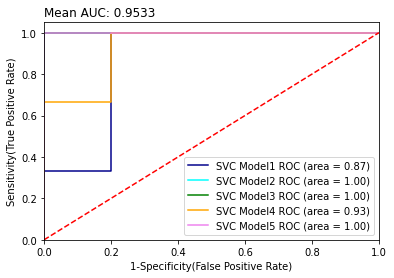

In [11]:
# Cross-validation for Support Vector Machine
color_list = ['darkblue', 'cyan', 'green', 'orange', 'violet']
param_grid = {
    'svc__C': 10.0**np.arange(-2, 2, step = 0.05),
    'svc__gamma': 10.0**np.arange(-2, 2, step = 0.05),
    'svc__kernel': ['rbf']
}
i = 0
svm_scores = []
acc_scores = []
svm_spec = []
svm_sens = []
svm_npv = []
svm_ppv = []
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
for train_index, test_index in kf.split(X_over, y_over):
    i += 1
    X_train, X_test = X_over.iloc[train_index], X_over.iloc[test_index]
    y_train, y_test = y_over[train_index], y_over[test_index]

    svm_pipe = make_pipeline(
        StandardScaler(),
        SVC(probability = True)
    )
    grid_search = GridSearchCV(
        svm_pipe, 
        param_grid, 
        cv = 5, 
        scoring = 'roc_auc',
        n_jobs = -1
    )
    grid_search.fit(X_train, y_train)
    best_svm = grid_search.best_params_

    svm_searched = SVC(C = best_svm['svc__C'], gamma = best_svm['svc__gamma'], kernel=best_svm['svc__kernel'], probability=True)
    fit_svm = svm_searched.fit(cust_standardize(X_train), y_train)
    roc_score = roc_auc_score(y_test, fit_svm.decision_function(cust_standardize(X_test)))
    y_pred = fit_svm.predict(cust_standardize(X_test))
    acc_score = accuracy_score(y_test, y_pred)
    acc_scores += [acc_score]
    svm_scores += [roc_score]
    confusion = confusion_matrix(y_test, y_pred)
    svm_spec += [confusion[0,0]/(confusion[0,0] + confusion[0,1])]
    svm_sens += [confusion[1,1]/(confusion[1,0] + confusion[1,1])]
    svm_ppv += [confusion[0,0]/(confusion[0,0] + confusion[1,0])]
    svm_npv += [confusion[1,1]/(confusion[0,1] + confusion[1,1])]

    if(i<=5):
        fpr, tpr, thresholds = roc_curve(y_test, fit_svm.predict_proba(cust_standardize(X_test))[:,1])
        rgb = (random.random(), random.random(), random.random())
        plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ("SVC Model{}".format(i), roc_score), c=color_list[i-1])
        
print("Average AUC for Support Vector Machine Model is {}".format(sum(svm_scores)/len(svm_scores)))
print("2.5 quantile {} for AUC, 97.5 quantile {} for AUC.".format(np.quantile(svm_scores, 0.025), np.quantile(svm_scores, 0.975)))
print("Average accuracy for Support Vector Machine Model is {}".format(sum(acc_scores)/len(acc_scores)))
print("2.5 quantile {} for accuracy, 97.5 quantile {} for accuracy.".format(np.quantile(acc_scores, 0.025), np.quantile(acc_scores, 0.975)))
print("Average specificity for Support Vector Machine Model is {}".format(sum(svm_spec)/len(svm_spec)))
print("2.5 quantile {} for specificity, 97.5 quantile {} for specificity.".format(np.quantile(svm_spec, 0.025), np.quantile(svm_spec, 0.975)))
print("Average sensitivity for Support Vector Machine Model is {}".format(sum(svm_sens)/len(svm_sens)))
print("2.5 quantile {} for sensitivity, 97.5 quantile {} for sensitivity.".format(np.quantile(svm_sens, 0.025), np.quantile(svm_sens, 0.975)))
print("Average ppv for Support Vector Machine Model is {}".format(sum(svm_ppv)/len(svm_ppv)))
print("2.5 quantile {} for ppv, 97.5 quantile {} for ppv.".format(np.quantile(svm_ppv, 0.025), np.quantile(svm_ppv, 0.975)))
print("Average npv for Support Vector Machine Model is {}".format(sum(svm_npv)/len(svm_npv)))
print("2.5 quantile {} for npv, 97.5 quantile {} for npv.".format(np.quantile(svm_npv, 0.025), np.quantile(svm_npv, 0.975)))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
# plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.title('Mean AUC: {:.4f}'.format(sum(svm_scores)/len(svm_scores)), loc = 'left')
plt.savefig("Integrated_result.png", dpi = 300)
plt.show()

In [13]:
integrated_dataset.columns

Index(['Sex', 'Age', 'Pos', 'PCK', 'stage', 'Metastatis', 'Loc', 'Hemo',
       'Plate', 'WBC', 'Lyph', 'LDH', 'White protein', 'Chemo', 'Hist',
       'Smoke', 'Drink', 'meanValue', 'HISTO_Kurtosis',
       'SHAPE_Sphericity (only for 3D ROI (nZ>1)', 'GLCM_Contrast',
       'GLRLM_RLNU', 'NGLDM_Busyness', 'Target'],
      dtype='object')

In [14]:
integrated_dataset.to_csv("integrated_data.csv")